c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Fitness: 0.3752643996957822, Generation: 0, Parent Index: 0
Fitness: 0.6646073443502182, Generation: 0, Parent Index: 1
Fitness: 0.24436453704289474, Generation: 0, Parent Index: 2
Fitness: 0, Generation: 0, Parent Index: 3
Fitness: 0.5250473221927288, Generation: 0, Parent Index: 4
Fitness: 0.3104346526713963, Generation: 0, Parent Index: 5
Fitness: 0.8819128764636497, Generation: 0, Parent Index: 6
Fitness: 0.4587372224870925, Generation: 0, Parent Index: 7
Fitness: 0, Generation: 0, Parent Index: 8
Fitness: 0.6233588670790685, Generation: 0, Parent Index: 9
Fitness: 0.6969423096340276, Generation: 1, Parent Index: 2
Fitness: 0.8813835773983352, Generation: 1, Parent Index: 3
Fitness: 0.6357603324261534, Generation: 1, Parent Index: 4
Fitness: 0.8794577546737905, Generation: 1, Parent Index: 6
Fitness: 0.8763029562856557, Generation: 1, Parent Index: 7
Fitness: 0.6392122232299648, Generation: 1, Parent Index: 8
Fitness: 0.887489512962712, Generation: 1, Parent Index: 9
Fitness: 0.890

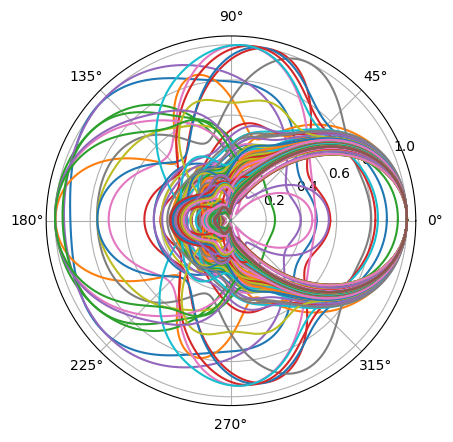

In [ ]:
import pygad 
import numpy as np 
from scipy import linalg 
from solver_for_Pocklington_equation import directional_pattern
import matplotlib.pyplot as plt

light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10

delta_z = light_speed / frequency / 1e2

phi = np.linspace(1e-6, 2*np.pi-1e-6, 1000)
P = []
fit = []
def aim_func(phi):
    f = np.zeros(len(phi))
    for i in range (len(f)):
        f[i] = max(0,np.sin(np.pi/2 - phi[i]))**2
    return f

def fitness_func(ga_instance, solution, solution_idx):
    
    generation = ga_instance.generations_completed
    
    element_position = np.zeros((num_elements, 3)) 
    element_length = np.zeros(num_elements)           
    for i in range(num_elements):
        element_position[i] = [0, solution[i], 0] 
        element_length[i] = solution[num_elements + i]     
    wire_radius = np.full(num_elements, 3.175e-3)
    source_position = np.array([element_position[0]], dtype=float) 
    
    for i in range(len(element_position)-1):
        for j in range(i+1,len(element_position)): 
            if(abs(element_position[i][1] - element_position[j][1]) <= 4*max(wire_radius[i],wire_radius[j])):
                fitness = 0
                print(f'Fitness: {fitness}, Generation: {generation}, Parent Index: {solution_idx}')
                return 0
    P_total, phi = directional_pattern(frequency, delta_z, incident_voltage, element_position, element_length, wire_radius, source_position)[7:9]
    fitness = np.dot(aim_func(phi), P_total/np.max(P_total)) / np.linalg.norm(aim_func(phi)) / np.linalg.norm(P_total/np.max(P_total))
    plt.polar(phi, P_total/np.max(P_total))
    
    print(f'Fitness: {fitness}, Generation: {generation}, Parent Index: {solution_idx}')
    P.append(P_total)
    fit.append(fitness)
    return fitness

num_elements = 8

num_generations = 50
num_parents_mating = 2
sol_per_pop = 10
num_genes = 2 * num_elements  

min_pos, max_pos = 0.0, 1.5 * light_speed / frequency
min_length, max_length = light_speed / frequency * 0.4, light_speed / frequency * 0.55
position_limit = [min_pos, max_pos]  
length_limit = [min_length, max_length]  

gene_space = []

for _ in range(num_elements):
    gene_space.append(position_limit)
for _ in range(num_elements):
    gene_space.append(length_limit)
    

initial_population = np.random.uniform(low=[g[0] for g in gene_space], high=[g[1] for g in gene_space], size=(sol_per_pop, num_genes))

def mutation_func(offspring, ga_instance):
    
    for chromosome_idx in range(offspring.shape[0]):
        
        chance_of_mutation = np.random.uniform(-1,1)
        fitness_values = ga_instance.last_generation_fitness 
        fitness_value = fitness_values[chromosome_idx]
        if fitness_value >= 0.97:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.8 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/250, max_pos/250) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/250, max_length/250) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)  
                        
        elif fitness_value >= 0.95:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.9 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/100, max_pos/100) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/100, max_length/100) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)  
                        
        elif fitness_value >= 0.925:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.75 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/50, max_pos/50) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/50, max_length/50) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)
                if chance_of_mutation <= -0.9 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/10, max_pos/10) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)

                            
        elif fitness_value >= 0.90:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.7 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/35, max_pos/35) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/35, max_length/35) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)
                if chance_of_mutation <= -0.7 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/10, max_pos/10) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)

        elif fitness_value >= 0.80:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.7 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/20, max_pos/20) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/20, max_length/20) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)
                elif chance_of_mutation <= -0.95 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/10, max_pos/10) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                                              
        elif fitness_value >= 0.70:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.7 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/10, max_pos/10) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                    else :
                        mutation_value = np.random.uniform(-max_length/10, max_length/10) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_length, max_length)
                        
        elif fitness_value < 0.70:
            for gene_idx in range(offspring.shape[1]):
                chance_of_mutation = np.random.uniform(-1,1)
                if chance_of_mutation >= 0.65 :
                    if gene_idx < num_elements:
                        mutation_value = np.random.uniform(-max_pos/2, max_pos/2) 
                        offspring[chromosome_idx, gene_idx] += mutation_value
                        offspring[chromosome_idx, gene_idx] = np.clip(offspring[chromosome_idx, gene_idx], min_pos, max_pos)
                        
    return offspring

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population=initial_population,
                       gene_space=gene_space,
                       mutation_type=mutation_func,
                       parent_selection_type='tournament',
                       crossover_type='single_point') 

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Лучшее решение:", solution) 
print("Оценка лучшего решения:", solution_fitness) 

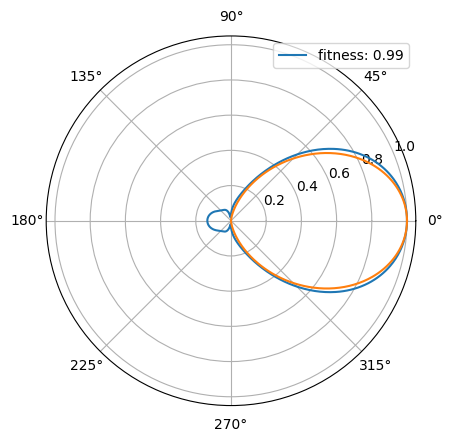

In [13]:
delta_z = light_speed / frequency / 5e2
element_position = np.zeros((num_elements, 3)) 
element_length = np.zeros(num_elements)           
for i in range(num_elements):
    element_position[i] = [0, solution[i], 0] 
    element_length[i] = solution[num_elements + i]     
wire_radius = np.full(num_elements, 3.175e-3)
source_position = np.array([element_position[0]], dtype=float) 
R, R_block, element_num, incident_field, impedance, current, current_block, P_total, phi = directional_pattern (frequency, delta_z, incident_voltage, element_position, element_length, wire_radius, source_position)
fitness = np.dot(aim_func(phi), P_total) / np.linalg.norm(aim_func(phi)) / np.linalg.norm(P_total)
plt.polar(phi, P_total/np.max(P_total), label = f'fitness: {np.round(solution_fitness,3)}')
plt.polar(phi,aim_func(phi))
plt.legend()
plt.show()

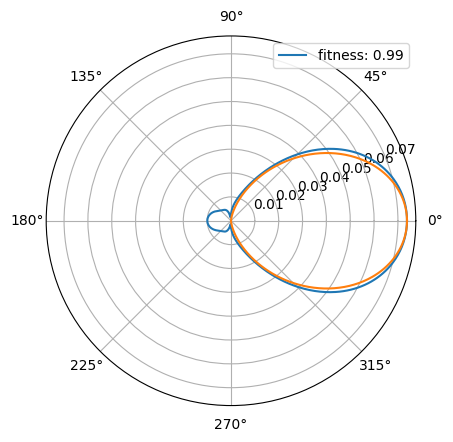

In [14]:
plt.polar(phi, P_total, label = f'fitness: {np.round(solution_fitness,3)}')
plt.polar(phi,aim_func(phi)*np.max(P_total))
plt.legend()
plt.show()

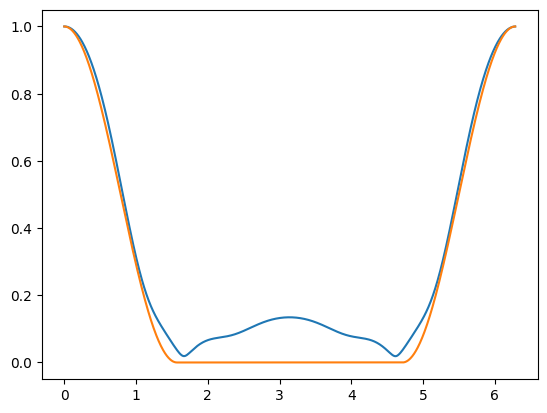

In [15]:
plt.plot(phi, P_total/np.max(P_total))
plt.plot(phi,aim_func(phi))

Text(0.5, 0, 'Number of configuration')

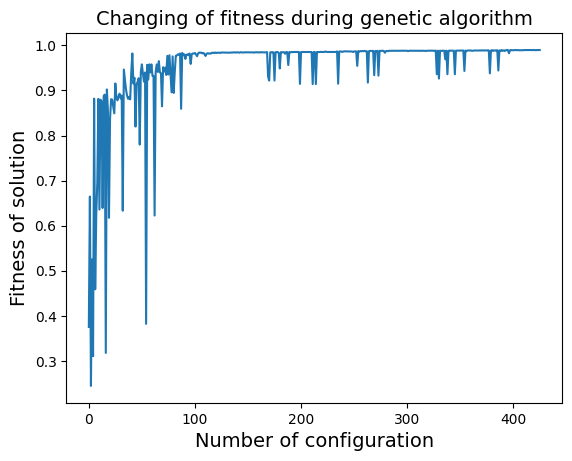

In [16]:
plt.plot(np.arange(len(fit)),fit)
plt.title('Changing of fitness during genetic algorithm', size = 14)
plt.ylabel('Fitness of solution', size = 14)
plt.xlabel('Number of configuration', size = 14)

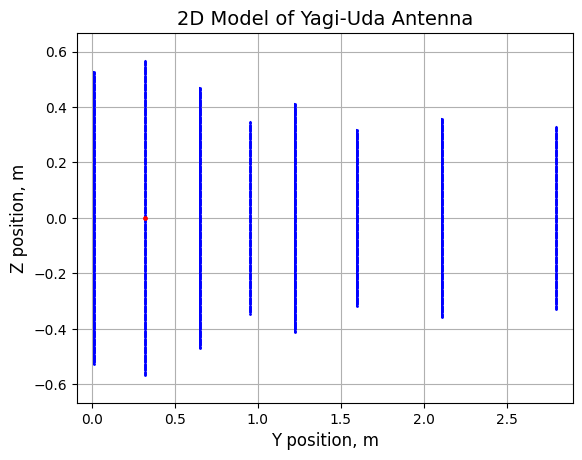

In [17]:
from visualization import plot_2dmodel, plot_together, plot_separately, current_distribution_2d, current_distribution_3d

plot_2dmodel(R, source_position, sum(element_num), delta_z)
#plot_together(R_block, current_block)
#plot_separately(R_block, current_block)
current_distribution_2d(R, current)
#current_distribution_3d(R, source_position, R_block, current_block)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

num_frames = len(P)

frames = []

for i in range(num_frames):
    plt.figure(figsize=(6, 6))
    
    plt.polar(phi, P[i]/np.max(P[i]), label = f'fitness: {np.round(fit[i],3)}')  
    plt.polar(phi,aim_func(phi))
    plt.legend()
    plt.title(f"Configuration {i + 1}")
    
    plt.savefig('temp_frame.png')
    plt.close()  
    
    frames.append(imageio.imread('temp_frame.png'))

imageio.mimsave('Evalution_of_optimizator.gif', frames, duration=1.5)  



C:\Users\lukas\AppData\Local\Temp\ipykernel_9116\2234934920.py:20: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

